In [1]:
import numpy as np #the numbering/maths common package associated with python
import matplotlib.pyplot as plt #plotting package the inline statement is to get ipython to display the plots
%matplotlib inline  
import pandas as pd   #common for in-memory representation of complex data colletions for python
import xarray as xr   #used for the manipulation of netcdf files
from statsmodels.nonparametric.smoothers_lowess import lowess 
# from mpl_toolkits.basemap import Basemap  # for plotting maps. it's old though, could also use Cartopy
from datetime import datetime

# import cmocean   # for some more colour maps


import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import BoundaryNorm
import cartopy.feature as cfeature

def average_da(self, dim=None, weights=None):
    """
    weighted average for DataArrays

    Parameters
    ----------
    dim : str or sequence of str, optional
        Dimension(s) over which to apply average.
    weights : DataArray
        weights to apply. Shape must be broadcastable to shape of self.

    Returns
    -------
    reduced : DataArray
        New DataArray with average applied to its data and the indicated
        dimension(s) removed.

    """

    if weights is None:
        return self.mean(dim)
    else:
        if not isinstance(weights, xr.DataArray):
            raise ValueError("weights must be a DataArray")

        # if NaNs are present, we need individual weights
        if self.notnull().any():
            total_weights = weights.where(self.notnull()).sum(dim=dim)
        else:
            total_weights = weights.sum(dim)

        return (self * weights).sum(dim) / total_weights

# -----------------------------------------------------------------------------

def average_ds(self, dim=None, weights=None):
    """
    weighted average for Datasets

    Parameters
    ----------
    dim : str or sequence of str, optional
        Dimension(s) over which to apply average.
    weights : DataArray
        weights to apply. Shape must be broadcastable to shape of data.

    Returns
    -------
    reduced : Dataset
        New Dataset with average applied to its data and the indicated
        dimension(s) removed.

    """

    if weights is None:
        return self.mean(dim)
    else:
        return self.apply(average_da, dim=dim, weights=weights)
def xarray_average(data, dim=None, weights=None):
    """
    weighted average for xray objects

    Parameters
    ----------
    data : Dataset or DataArray
        the xray object to average over
    dim : str or sequence of str, optional
        Dimension(s) over which to apply average.
    weights : DataArray
        weights to apply. Shape must be broadcastable to shape of data.

    Returns
    -------
    reduced : Dataset or DataArray
        New xray object with average applied to its data and the indicated
        dimension(s) removed.

    """

    if isinstance(data, xr.Dataset):
        return average_ds(data, dim, weights)
    elif isinstance(data, xr.DataArray):
        return average_da(data, dim, weights)
    else:
        raise ValueError("date must be an xray Dataset or DataArray")

def weighted_mean(df, variable):
    lats_radians = np.deg2rad(df.lat)      # convert latitude to radians
    # use the cosine of the latitudes (in radians) as weights for the average
    lats_weights = np.cos(lats_radians)
    
    # find the zonal mean by averaging along latitude circles
    variable_ave_zonal = df[variable].mean(dim='lon', keep_attrs=True)
    # take the weighted average of those using weights calculated earlier
#     variable_weighted_ave = np.average(variable_ave_zonal, axis=1, weights=lats_weights)

    # do the weighted average but keep it in xarray (so that we keep time). gives the same answer as above
    variable_weighted_ave_xr = xarray_average(variable_ave_zonal, dim='lat', weights=lats_weights)
    return variable_weighted_ave_xr

import pyleoclim as pyleo
import xarray
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

In [2]:
filepath = ('/Users/jessicahargreaves/Documents_2/PhD/Coding/Coral_results/Coral_final/')
Composite = pd.read_excel(filepath +'Christmas_composite_monthly_SST_d18O.xlsx') #https://www.apcc21.org/ser/indic.do?lang=en#grap2 
time=(pd.date_range(start='1900/2/1', periods=1426, freq='MS'))+ pd.offsets.Day(14)

Composite


,Age,d13C,MgCa,SrCa_anayltical,d18O_analytical,SrCa_Data,d18O_Data,SrCa_Anomalies,d18O_Anomalies,Date_SST,...,SST_16,SST_84,SST_5,SST_95,Date,d18Osw,d18Osw_16,d18Osw_84,d18Osw_5,d18Osw_95
0,1900.125000,-1.373924,4.000992,0.01,0.06,9.1509,-4.8673,0.2068,0.4276,1900.1250,...,-4.0214,-2.8493,-4.5915,-2.6015,1900.1250,-0.3090,-0.4850,-0.1682,-0.6249,-0.0907
1,1900.208333,-1.806387,4.215021,0.01,0.06,9.1168,-5.2462,0.1727,0.0487,1900.2083,...,-3.3371,-2.3698,-3.8199,-2.1558,1900.2083,-0.5660,-0.7135,-0.4428,-0.8323,-0.3735
2,1900.291667,-1.452743,4.121344,0.01,0.06,9.0791,-5.0437,0.1350,0.2512,1900.2917,...,-2.6266,-1.8337,-3.0251,-1.6635,1900.2917,-0.2305,-0.3546,-0.1253,-0.4521,-0.0641
3,1900.375000,-1.379733,4.261246,0.01,0.06,8.9769,-5.0945,0.0328,0.2004,1900.3750,...,-0.7234,-0.3559,-0.8778,-0.2555,1900.3750,0.0839,0.0091,0.1568,-0.0406,0.2022
4,1900.458333,-1.624681,4.417536,0.01,0.06,8.9794,-5.2152,0.0353,0.0797,1900.4583,...,-0.7799,-0.3940,-0.9363,-0.2912,1900.4583,-0.0484,-0.1238,0.0261,-0.1766,0.0723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,2018.541667,-3.707864,10.004179,0.01,0.06,9.1414,-5.3957,0.1973,-0.1008,2018.5417,...,-3.7897,-2.7106,-4.3520,-2.4758,2018.5417,-0.8013,-0.9652,-0.6703,-1.0965,-0.5939
1422,2018.625000,-3.570000,9.942823,0.01,0.06,9.0604,-5.4325,0.1163,-0.1376,2018.6250,...,-2.2790,-1.5725,-2.6071,-1.4139,2018.6250,-0.5534,-0.6659,-0.4553,-0.7537,-0.3987
1423,2018.708333,-3.303190,10.428264,0.01,0.06,9.1314,-5.3929,0.1873,-0.0980,2018.7083,...,-3.6155,-2.5655,-4.1402,-2.3382,2018.7083,-0.7628,-0.9223,-0.6350,-1.0530,-0.5599
1424,2018.791667,-3.524347,10.402446,0.01,0.06,9.0330,-5.4904,0.0889,-0.1955,2018.7917,...,-1.7564,-1.1852,-2.0373,-1.0529,2018.7917,-0.5129,-0.6101,-0.4272,-0.6823,-0.3756


In [3]:
Composite_d18O = xr.Dataset({'d18O':(['time'],Composite.d18O_Data),
                            'd18O_anom':(['time'],Composite.d18O_Anomalies),
                       'analytical':(['time'],Composite.d18O_analytical)},
                   coords={'time':time})
# Composite_SrCa_new = xr.Dataset({#'d18O':(['time'],Composite.d18O)},
#                        'SrCa_new':(['time'],Composite.SrCa_new)},
#                    coords={'time':time})

Composite_SrCa = xr.Dataset({'analytical':(['time'],Composite.SrCa_anayltical),
                       'SrCa':(['time'],Composite.SrCa_Data),
                        'SrCa_anom':(['time'],Composite.SrCa_Anomalies)},
                   coords={'time':time})
Composite_MgCa = xr.Dataset({#'d18O':(['time'],Composite.d18O)},
                       'MgCa':(['time'],Composite.MgCa)},
                   coords={'time':time})

Composite_Derived_SST = xr.Dataset({'SST':(['time'],Composite.SST),
                                   'SST_16':(['time'],Composite.SST_16),
                                   'SST_84':(['time'],Composite.SST_84),
                                   'SST_5':(['time'],Composite.SST_5),
                                   'SST_95':(['time'],Composite.SST_95)},
                    #   'SrCa':(['time'],Composite.SrCa),
                   coords={'time':time})

Composite_Derived_d18Osw = xr.Dataset({'d18Osw':(['time'],Composite.d18Osw),
                                   'd18Osw_16':(['time'],Composite.d18Osw_16),
                                   'd18Osw_84':(['time'],Composite.d18Osw_84),
                                   'd18Osw_5':(['time'],Composite.d18Osw_5),
                                   'd18Osw_95':(['time'],Composite.d18Osw_95)},
                    #   'SrCa':(['time'],Composite.SrCa),
                   coords={'time':time})
Composite_Derived_d18Osw 

<xarray.Dataset>
Dimensions:    (time: 1426)
Coordinates:
  * time       (time) datetime64[ns] 1900-02-15 1900-03-15 ... 2018-11-15
Data variables:
    d18Osw     (time) float64 -0.309 -0.566 -0.2305 ... -0.7628 -0.5129 -0.6256
    d18Osw_16  (time) float64 -0.485 -0.7135 -0.3546 ... -0.9223 -0.6101 -0.7288
    d18Osw_84  (time) float64 -0.1682 -0.4428 -0.1253 ... -0.635 -0.4272 -0.5363
    d18Osw_5   (time) float64 -0.6249 -0.8323 -0.4521 ... -1.053 -0.6823 -0.8076
    d18Osw_95  (time) float64 -0.0907 -0.3735 -0.0641 ... -0.3756 -0.4807

In [ ]:
dap_url='http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/Hadley_EN/4.2.2/analyses_c13'
data = xr.open_dataset(dap_url)
data

sss_EN4=data['salt'].sel(lev =slice(5,20), lat=slice(-12,-9), lon=slice(103,106))
sss_EN4_wide=data['salt'].sel(lev =slice(5,20), lat=slice(-15,-5), lon=slice(100,110))
average_sss_EN4 = sss_EN4.mean(['lat','lon'], skipna=True)
average_sss_EN4_w = sss_EN4_wide.mean(['lat','lon'], skipna=True)
average_sss_EN4
average_sss_EN4_wide = average_sss_EN4_w.mean(['lev'])
average_sss_EN4_l = average_sss_EN4.mean(['lev'])
average_sss_EN4_l


In [7]:
Composite_d180sw = xr.Dataset({#'d18O':(['time'],Composite.d18O)},
                       'd18Osw':(['time'],Composite_Derived_d18Osw.d18Osw.values),
#                         'sss':(['time'],ave_EN4_compar.values)
    },
                   coords={'time':time})
test_d180sw=Composite_d180sw.dropna('time')


test = test_d180sw.isel(time=slice(711,1400))

comp3month_d18Osw = test.resample(time = '6M').mean()
# comp_3month['time'] = time_3
comp3month_d18Osw

# plt.scatter(test.sss.values,test.d18Osw.values,c='#7570b3')

<xarray.Dataset>
Dimensions:  (time: 119)
Coordinates:
  * time     (time) datetime64[ns] 1960-04-30 1960-10-31 ... 2019-04-30
Data variables:
    d18Osw   (time) float64 0.2489 0.1283 0.1631 ... -0.2325 -0.4747 -0.6256

In [9]:

dap_url='http://apdrc.soest.hawaii.edu:80/dods/public_data/NOAA_SST/ERSST/monthly_v5'

data = xr.open_dataset(dap_url)
data

sst=data['sst'].sel(lat=slice(-11,-10), lon=slice(105,106))
average_ERSST = sst.mean(['lat','lon'])
average_ERSST = average_ERSST.isel(time=slice(553,1979))

average_ERSST

/Users/jessicahargreaves/opt/anaconda3/envs/spp2299/lib/python3.10/site-packages/xarray/coding/times.py:153: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.DataArray 'sst' (time: 1426)>
array([28.693562, 29.064196, 29.041492, ..., 25.984005, 26.978476,
       27.675604], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1900-02-15 1900-03-15 ... 2018-11-15

In [10]:

Composite_SrCa = xr.Dataset({#'d18O':(['time'],Composite.d18O)},
                       'SrCa':(['time'],Composite.SrCa_Data),
                        'sst':(['time'],average_ERSST.values),'d18O':(['time'],Composite.d18O_Data)
},
                   coords={'time':time})
Composite_SrCa
test1=Composite_SrCa.dropna('time')

test = test1.isel(time=slice(711,1131))

comp3month = test.resample(time = '4M').mean()
# comp_3month['time'] = time_3
comp3month

<xarray.Dataset>
Dimensions:  (time: 109)
Coordinates:
  * time     (time) datetime64[ns] 1960-04-30 1960-08-31 ... 1996-04-30
Data variables:
    SrCa     (time) float64 8.838 8.941 8.945 8.853 ... 8.909 8.941 8.943 8.949
    sst      (time) float32 29.44 28.02 27.73 28.79 ... 28.68 27.99 27.43 28.09
    d18O     (time) float64 -5.425 -5.21 -5.132 -5.442 ... -5.297 -5.298 -5.494

In [11]:

from pylr2 import regress2

# from here - https://github.com/OceanOptics/pylr2/blob/master/pylr2/regress2.py
results = regress2(test.sst.values,test.SrCa.values, _method_type_2="reduced major axis")
results
test['y_pred'] = results['predict']
test['resd'] = test.SrCa.values-test.y_pred
test

<xarray.Dataset>
Dimensions:  (time: 420, y_pred: 420)
Coordinates:
  * time     (time) datetime64[ns] 1960-04-15 1960-05-15 ... 1996-01-15
  * y_pred   (y_pred) float32 8.84 8.843 8.898 8.967 ... 8.974 8.924 8.944 8.923
Data variables:
    SrCa     (time) float64 8.838 8.892 8.94 8.962 ... 8.882 8.883 8.977 8.949
    sst      (time) float32 29.44 29.4 28.5 27.37 ... 27.27 28.07 27.75 28.09
    d18O     (time) float64 -5.425 -5.324 -5.258 -5.178 ... -5.298 -5.407 -5.494
    resd     (y_pred) float64 -0.001816 0.04918 0.04151 ... 0.03266 0.02626

In [12]:
from scipy.stats import anderson
anderson(test.resd.values)

# AndersonResult(statistic=0.15006999533388665,
#                critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]),
#                significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


AndersonResult(statistic=0.9148056086245901, critical_values=array([0.571, 0.65 , 0.78 , 0.909, 1.082]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-1.370784214815317e-07, scale=0.04624802454550149)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

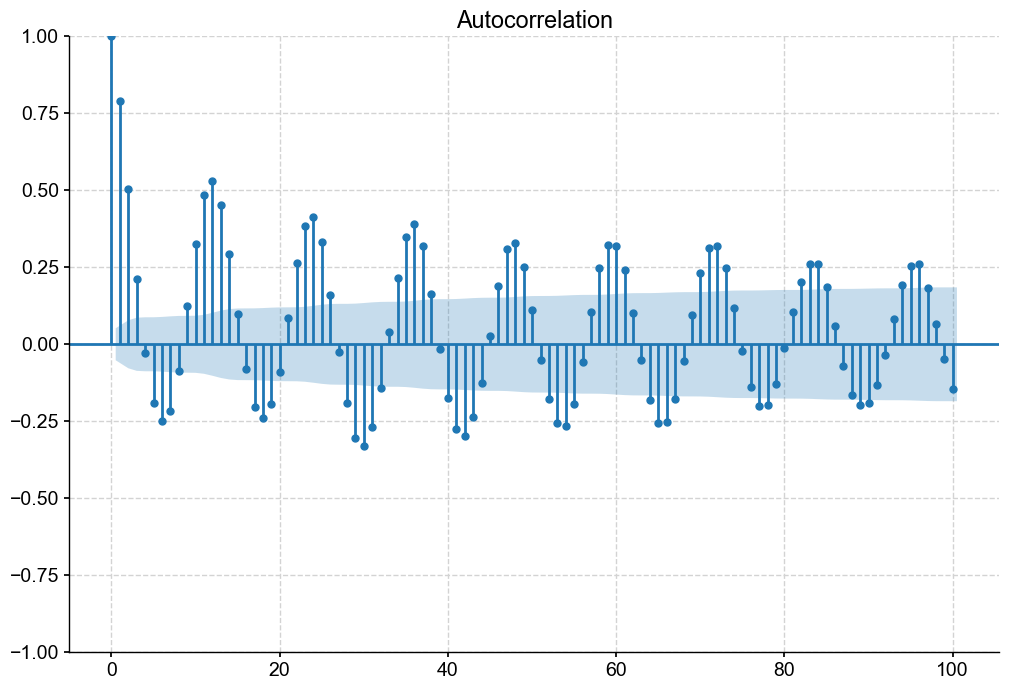

In [13]:
from statsmodels.graphics import tsaplots
import pymannkendall as mk

import statsmodels.api as sm

import sys
import os

# import geocat.viz.util as gvutil
# from geocat.viz import cmaps as gvcmaps
# rcParams["figure.figsize"] = 10, 6

import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(Composite_SrCa.SrCa, lags=100, ax=ax, missing='drop')
plt.show()

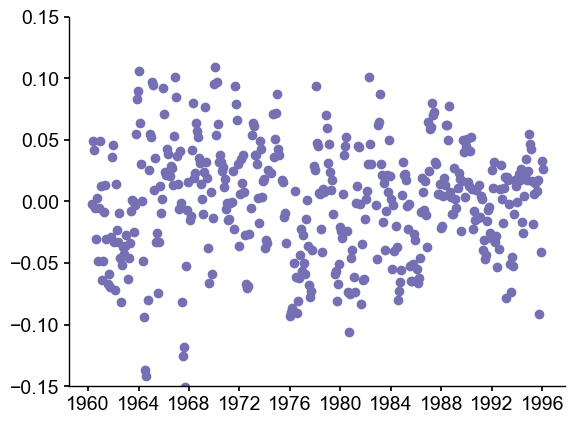

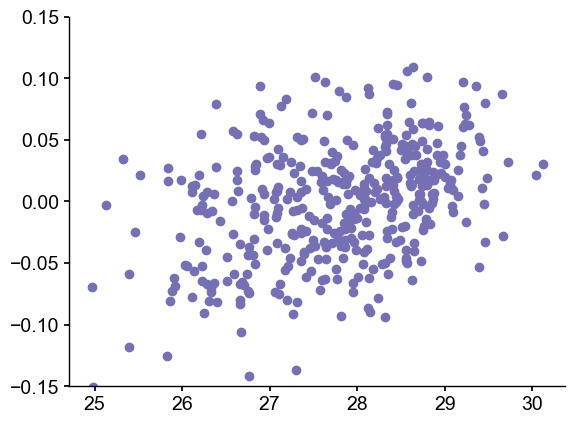

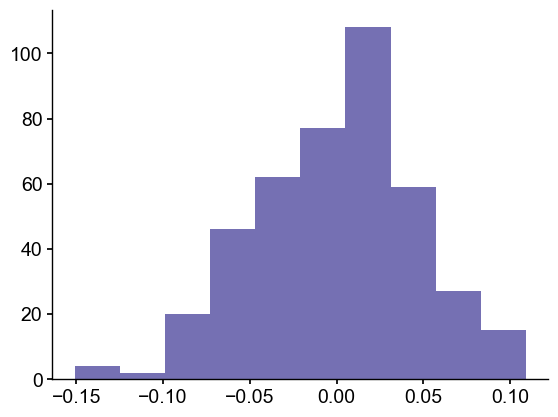

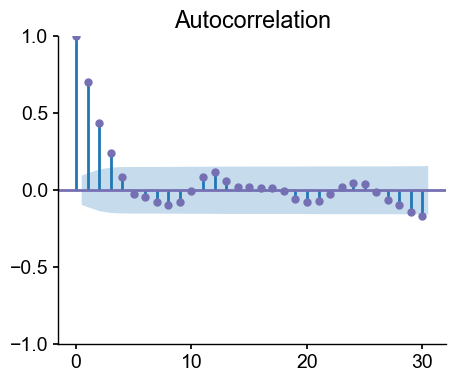

In [14]:
plt.scatter(test.time.values,test.resd,c='#7570b3')
plt.ylim([-0.15,0.15])
plt.grid(False)
plt.savefig('test.time.values,resd.pdf',dpi=600, bbox_inches='tight')
plt.show()
plt.scatter(test.sst.values,test.resd,c='#7570b3')
plt.ylim([-0.15,0.15])
plt.grid(False)
plt.savefig('test.sst.values,resd.pdf',dpi=600, bbox_inches='tight')
plt.show()
plt.hist(test.resd,color='#7570b3')
plt.grid(False)
plt.savefig('histmonth.pdf',dpi=600, bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(5, 4))
sm.graphics.tsa.plot_acf(test.resd, lags=30, ax=ax, missing='drop',c='#7570b3')
plt.grid(False)
plt.savefig('acf_month.pdf',dpi=600, bbox_inches='tight')
plt.show()

In [15]:
# a,b,corr_coeff,sb=lin_regr_func(comp3month.sst.values,comp3month.SrCa.values)
# a
# b
# y_pred = comp3month.sst.values*b+a
# resd = comp3month.SrCa.values-y_pred

# corr_coeff


from pylr2 import regress2

# from here - https://github.com/OceanOptics/pylr2/blob/master/pylr2/regress2.py
results = regress2(comp3month.sst.values,comp3month.SrCa.values, _method_type_2="reduced major axis")
results
comp3month['y_pred'] = results['predict']
comp3month['resd'] = comp3month.SrCa.values-comp3month.y_pred
comp3month
results

{'slope': -0.06767779039494347,
 'intercept': 10.822850354132713,
 'r': -0.6938586804626152,
 'std_slope': 0.005119365623815876,
 'std_intercept': 0.14238130427621537,
 'predict': array([8.830196 , 8.926498 , 8.946397 , 8.874268 , 8.991198 , 9.028609 ,
        8.917962 , 8.961331 , 8.995566 , 8.913659 , 8.987461 , 9.02378  ,
        8.881002 , 8.946066 , 9.005406 , 8.9232   , 8.984348 , 9.002825 ,
        8.883238 , 8.981365 , 8.989587 , 8.926912 , 9.0184765, 9.026403 ,
        8.932255 , 8.965987 , 8.967981 , 8.877435 , 8.945833 , 8.982523 ,
        8.866627 , 8.946109 , 8.976472 , 8.92338  , 8.9702   , 8.997023 ,
        8.9069195, 8.987643 , 8.997172 , 8.864404 , 8.912238 , 8.9626255,
        8.943229 , 8.990166 , 8.961821 , 8.885727 , 8.9593935, 8.989841 ,
        8.916779 , 8.996505 , 8.998122 , 8.900927 , 8.972511 , 9.007104 ,
        8.854698 , 8.947105 , 8.98176  , 8.882306 , 8.963548 , 8.961687 ,
        8.885317 , 8.949581 , 8.9685545, 8.90394  , 8.941342 , 8.965437 ,
       

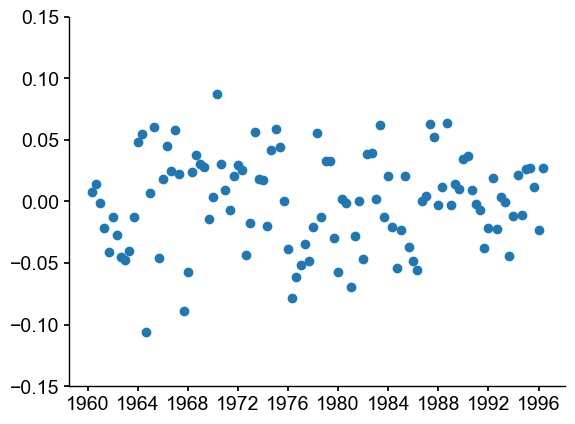

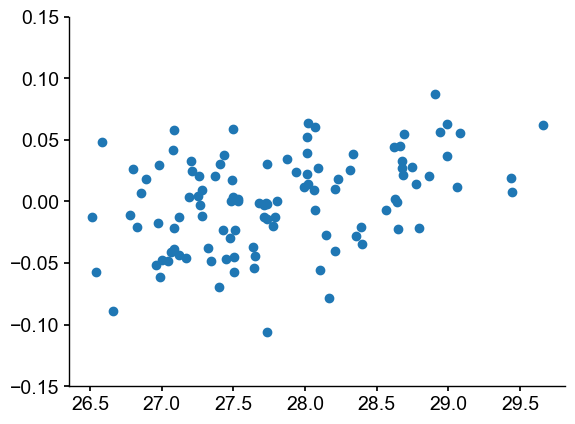

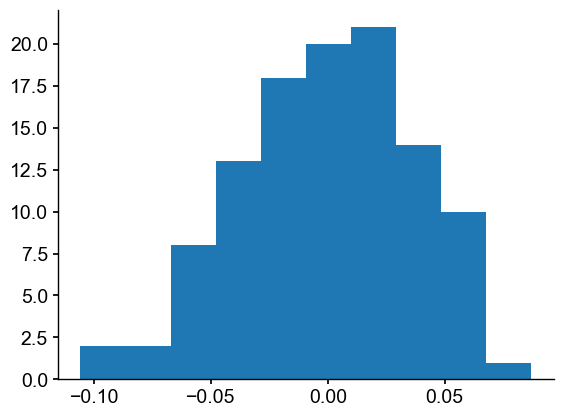

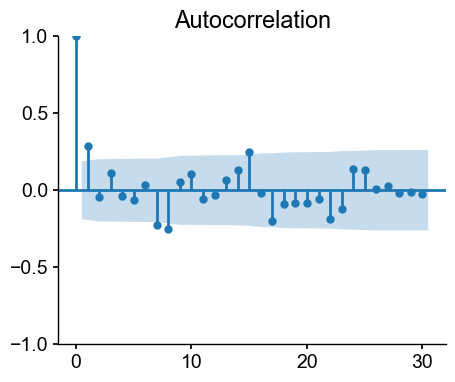

In [17]:
plt.scatter(comp3month.time.values,comp3month.resd,c='#1f78b4')
plt.grid(False)
plt.ylim([-0.15,0.15])
# plt.savefig('comp3month.time.values,resd.pdf',dpi=600, bbox_inches='tight',c='#1f78b4')
plt.show()
plt.scatter(comp3month.sst.values,comp3month.resd)
plt.grid(False)
plt.ylim([-0.15,0.15])
# plt.savefig('comp3month.sst.values,resd.pdf',dpi=600, bbox_inches='tight',c='#1f78b4')
plt.show()
plt.hist(comp3month.resd,color='#1f78b4')
plt.grid(False)
# plt.savefig('hist3month.pdf',dpi=600, bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(5, 4))
sm.graphics.tsa.plot_acf(comp3month.resd, lags=30, ax=ax, missing='drop',c='#1f78b4')
plt.grid(False)
# plt.savefig('acf_3month.pdf',dpi=600, bbox_inches='tight')
plt.show()